# **Automated Waste Classification Tool**

Jingqi Zhuang

## **Environment Setup**

In [ ]:
!pip install tensorflow.keras
!pip install tensorflow
!pip install callbacks
!pip install opencv-python

In [ ]:
# put any import here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import kagglehub
import random
import cv2
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet101V2, DenseNet201, MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from numpy.linalg import pinv, inv
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from numpy.linalg import pinv
from sklearn.linear_model import Lasso
from tensorflow.keras.models import load_model

In [ ]:
# If any randomization is involved and requires a fixed seed, use this seed number to ensure consistency.
seed = 42

## **Step 1: Data Preparation**



### **Load the dataset**

In [ ]:
sumn2u_garbage_classification_v2_path = kagglehub.dataset_download('sumn2u/garbage-classification-v2')
print('Data source import complete.')

Data source import complete.


In [ ]:
dataset_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'

### **Random visualize images**

For report use.

In [ ]:
def visualize_images(file_path, classes):

  selected_images = []
  random.seed(1)

  random_classes = random.sample(classes, 4)

  for i in range(4):
    random_class = random_classes[i]
    class_path = os.path.join(file_path, random_class)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    selected_images.append(image_path)

  plt.figure(figsize=(12, 8))
  for i, image_path in enumerate(selected_images):
    plt.subplot(2, 2, i+1)
    img = imread(image_path)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(image_path)))
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
# visualize_images(dataset_path, os.listdir(dataset_path))

### **Train Test Split & Data Augmentation**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 50

In [ ]:
# Training data generator (apply data augmentation to expand dataset)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,            # Random rotations up to 30 degrees
    width_shift_range=0.2,        # Horizontal shifts up to 20%
    height_shift_range=0.2,       # Vertical shifts up to 20%
    shear_range=0.2,              # Shear transformations
    zoom_range=0.2,               # Zoom in/out up to 20%
    horizontal_flip=True,         # Random horizontal flips
    fill_mode='nearest',          # Fill in missing pixels after transformations
    validation_split=0.20         # Reserve 20% of data for validation
)

# Validation data generation (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)

# Test data generation (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)

Manually perform train validation test split.

In [ ]:
# Paths
original_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'
split_path_ten = '/kaggle/working/garbage-dataset-split'  # Destination directory

# Create destination directories
splits = ['train', 'val', 'test']
for split in splits:
    for class_name in os.listdir(original_path):
        os.makedirs(os.path.join(split_path_ten, split, class_name), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# For each class folder
for class_name in os.listdir(original_path):
    class_dir = os.path.join(original_path, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Compute splits
    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=seed)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (test_ratio + val_ratio), random_state=seed)

    # Copy files
    for split_name, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in split_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(split_path_ten, split_name, class_name, file)
            shutil.copy2(src, dst)

In [ ]:
# Train generator
train_gen_ten = train_datagen.flow_from_directory(
    os.path.join(split_path_ten, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_gen_ten = val_datagen.flow_from_directory(
    os.path.join(split_path_ten, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_gen_ten = test_datagen.flow_from_directory(
    os.path.join(split_path_ten, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 18003 images belonging to 10 classes.
Found 5490 images belonging to 10 classes.
Found 5477 images belonging to 10 classes.


In [ ]:
print(test_gen_ten.image_shape)

(224, 224, 3)


### **Label Engineering: Biodegradable and non-Biodegradable**

In [ ]:
# Define biodegradable and non-biodegradable groups
biodegradable = ['biological', 'paper', 'cardboard', 'clothes', 'shoes']
non_biodegradable = ['metal', 'glass', 'battery', 'trash', 'plastic']

In [ ]:
# Paths
binary_path = '/kagglegarbage_dataset/Binary Labels'

# Create destination folders
os.makedirs(os.path.join(binary_path, 'biodegradable'), exist_ok=True)
os.makedirs(os.path.join(binary_path, 'non_biodegradable'), exist_ok=True)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Assign label
        if class_name in biodegradable:
            label_folder = 'biodegradable'
        elif class_name in non_biodegradable:
            label_folder = 'non_biodegradable'
        else:
            raise ValueError(f"Unknown class: {class_name}")

        # Destination path
        dst_dir = os.path.join(binary_path, label_folder)
        new_file_path = os.path.join(dst_dir, f"{class_name}_{img_file}")

        # Copy and rename
        shutil.copy2(img_path, new_file_path)

In [ ]:
# visualize_images(binary_path, os.listdir(binary_path))

Manually perform train test split.

In [ ]:
split_path = '/kagglegarbage_dataset/Binary_Split'
categories = ['biodegradable', 'non_biodegradable']

# Create folder structure
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(split_path, split, category), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for category in categories:
    class_dir = os.path.join(binary_path, category)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Compute splits
    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=seed)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=seed)

    # Copy files to destination folders
    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for img_file in split_files:
            src = os.path.join(class_dir, img_file)
            dst = os.path.join(split_path, split, category, img_file)
            shutil.copy2(src, dst)

In [ ]:
train_gen_binary = train_datagen.flow_from_directory(
    os.path.join(split_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen_binary = val_datagen.flow_from_directory(
    os.path.join(split_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen_binary = test_datagen.flow_from_directory(
    os.path.join(split_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

## **Step 2: Binary Classification**

The first-stage model classifies images as biodegradable or non-biodegradable using lightweight pre-trained CNNs (e.g., MobileNet, ResNet) with **transfer learning**.

**Pre-trained model selections:**

- mobilenetv2: 3.5M Parameters (most lightweight choice)

### **2.1 Pre-trained Model: mobilenetv2**

Use the pre-trained model with the smallest number of parameters.

Regularization Technique:
- Dropout layer
- Early Stopping




In [ ]:
def mobilenet_model_binary():
    inputs = Input(shape=IMG_SIZE + (3,))

    # Base model
    mobilenet_base = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')
    for layer in mobilenet_base.layers:
        layer.trainable = False

    x = mobilenet_base.output

    # flatten layer
    x = GlobalAveragePooling2D()(x)

    # fully-connected layer
    x = Dense(128, activation='relu')(x)

    # dropout layer
    x = Dropout(0.4)(x)

    # output layer
    x = Dense(1, activation='sigmoid')(x)  # Final sigmoid for binary

    model = Model(inputs=inputs, outputs=x)

    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy'],
        optimizer=optimizers.Adam(learning_rate=0.001)
    )

    return model

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',     # Stop based on val_accuracy
    min_delta=0.001,            # Minimum improvement to be considered “better”
    patience=3,                 # Number of epochs with <0.001 improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [ ]:
epochs = 15

# fit the model using training set
# Compile and fit the model
binary_model = mobilenet_model_binary()

history = binary_model.fit(
    train_gen_binary,
    validation_data=val_gen_binary,
    callbacks=[early_stop],
    steps_per_epoch=train_gen_binary.samples // BATCH_SIZE,
    validation_steps=val_gen_binary.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Epoch 1/15
276/276 - 179s - 648ms/step - accuracy: 0.9120 - loss: 0.2189 - val_accuracy: 0.9661 - val_loss: 0.1017
Epoch 2/15
276/276 - 8s - 28ms/step - accuracy: 0.9600 - loss: 0.1214 - val_accuracy: 0.9658 - val_loss: 0.1032
Epoch 3/15
276/276 - 167s - 607ms/step - accuracy: 0.9465 - loss: 0.1411 - val_accuracy: 0.9614 - val_loss: 0.1036
Epoch 4/15
276/276 - 9s - 31ms/step - accuracy: 0.9000 - loss: 0.2521 - val_accuracy: 0.9600 - val_loss: 0.1105
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Evaluate the model on the test set
predictions = binary_model.predict(test_gen_binary, verbose=1)
# Since it's binary classification with sigmoid output:
predicted_classes = (predictions > 0.5).astype(int).flatten()
# True classes from generator
true_classes = test_gen_binary.classes

# Classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)
print("Accuracy:", report['accuracy'])

pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step
Accuracy: 0.9679595278246206


precision    recall  f1-score     support
0              0.966592  0.980237  0.973367  1771.00000
1              0.970060  0.949749  0.959797  1194.00000
accuracy       0.967960  0.967960  0.967960     0.96796
macro avg      0.968326  0.964993  0.966582  2965.00000
weighted avg   0.967989  0.967960  0.967902  2965.00000

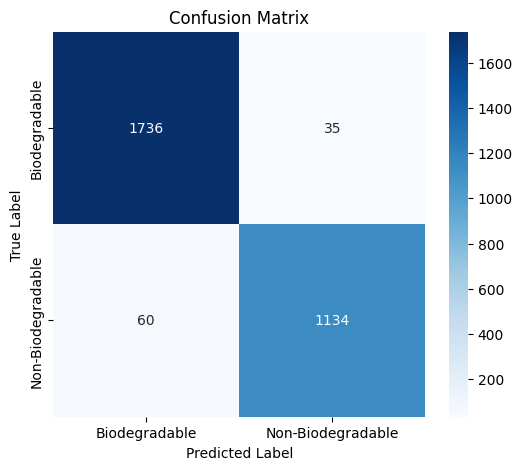

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Optional: class names
binary_class_names = ['Biodegradable', 'Non-Biodegradable']

# Visualize using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Insights:**

- MobileNetV2, the model with the fewest parameters and 154 layers, delivered impressive performance, achieving **97% test accuracy**.

- For binary classification tasks, a lightweight pre-trained model with all base layers frozen can already provide strong results, minimizing computational cost while maintaining high accuracy.



### **2.2 Visualize the model: Grad-CAM**




In [ ]:
def preprocess_img(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img  # Return both array and original PIL image

def display_gradcam(original_img, heatmap, alpha=0.4):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)

    # Apply color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert PIL image to array
    img = np.array(original_img)

    # Overlay
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Display
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [ ]:
def make_gradcam_heatmap_binary(img_array, model, last_conv_layer_name):

    grad_model = Model(
    inputs=binary_model.input,
    outputs=[
        binary_model.get_layer(last_conv_layer_name).output,
        binary_model.output
    ])

    # Compute gradient of the top predicted class for the image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Binary classifier: index 0

    # Gradients of loss wrt conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the corresponding gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# main function: heatmap for binary classifier
def binary_gradcam(last_layer, model):

  # Define paths
  biodegradable_path = os.path.join(split_path, 'test/biodegradable')
  non_biodegradable_path = os.path.join(split_path, 'test/non_biodegradable')

  # Get all image filenames
  biodegradable_images = os.listdir(biodegradable_path)
  non_biodegradable_images = os.listdir(non_biodegradable_path)

  # Sample 6 random images from each class
  sampled_biodegradable = random.sample(biodegradable_images, 6)
  sampled_non_biodegradable = random.sample(non_biodegradable_images, 6)

  # Full paths
  img_paths_biodegradable = [os.path.join(biodegradable_path, fname) for fname in sampled_biodegradable]
  img_paths_non_biodegradable = [os.path.join(non_biodegradable_path, fname) for fname in sampled_non_biodegradable]


  for img_path in img_paths_biodegradable:
    img_array, original_img = preprocess_img(img_path, IMG_SIZE)

    # Get heatmap
    heatmap = make_gradcam_heatmap_binary(img_array, model, last_layer)

    # Overlay and display
    display_gradcam(original_img, heatmap)

In [ ]:
binary_model.summary()

In [ ]:
mobilenet_layer_name = 'Conv_1'
binary_gradcam(mobilenet_layer_name, binary_model)

## **Step 3: Multi-Class Classification Using Transfer Learning**


**Pre-trained model selections:**

- mobilenetv2: 3.5M Parameters

- densenet201: 20M Parameters

- resnet101: 44.6M Parameters



### **3.1 Pre-trained Model: mobilenetv2**

Use the pre-trained model with the smallest number of parameters.

Regularization Technique:
- Dropout layer
- Early Stopping

In [ ]:
def mobilenet_model_ten():

  inputs = Input(shape=IMG_SIZE + (3,))

  # Base model
  mobilenet_base = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')

  # freeze the whole base model
  for layer in mobilenet_base.layers:
        layer.trainable = False


  x = mobilenet_base.output

  # flatten layer
  x = GlobalAveragePooling2D()(x)


  # fully-connected layer
  x = Dense(256, activation='relu', name='tl_feat_dn')(x)


  # dropout layer
  x = Dropout(0.3)(x)

  # output layer
  outputs = Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  # Compile and train
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
epochs = 15

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',     # Stop based on val_accuracy
    min_delta=0.001,            # Minimum improvement to be considered “better”
    patience=3,                 # Number of epochs with <0.001 improvement before stopping
    restore_best_weights=True,
    verbose=1
)

# fit the model using training set
# Compile and fit the model
mobilenet_ten_model = mobilenet_model_ten()

history = mobilenet_ten_model.fit(
    train_gen_ten,
    validation_data=val_gen_ten,
    callbacks=[early_stop],
    steps_per_epoch=train_gen_ten.samples // BATCH_SIZE,
    validation_steps=val_gen_ten.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Epoch 1/15
276/276 - 189s - 684ms/step - accuracy: 0.8143 - loss: 0.5744 - val_accuracy: 0.8814 - val_loss: 0.3692
Epoch 2/15
276/276 - 8s - 28ms/step - accuracy: 0.8200 - loss: 0.4245 - val_accuracy: 0.8824 - val_loss: 0.3580
Epoch 3/15
276/276 - 171s - 619ms/step - accuracy: 0.8793 - loss: 0.3675 - val_accuracy: 0.9166 - val_loss: 0.2674
Epoch 4/15
276/276 - 8s - 29ms/step - accuracy: 0.9000 - loss: 0.2887 - val_accuracy: 0.9169 - val_loss: 0.2658
Epoch 5/15
276/276 - 172s - 622ms/step - accuracy: 0.8925 - loss: 0.3175 - val_accuracy: 0.9200 - val_loss: 0.2575
Epoch 6/15
276/276 - 8s - 29ms/step - accuracy: 0.9000 - loss: 0.3829 - val_accuracy: 0.9227 - val_loss: 0.2567
Epoch 7/15
276/276 - 173s - 628ms/step - accuracy: 0.9053 - loss: 0.2888 - val_accuracy: 0.9278 - val_loss: 0.2403
Epoch 8/15
276/276 - 8s - 29ms/step - accuracy: 0.9200 - loss: 0.1625 - val_accuracy: 0.9264 - val_loss: 0.2418
Epoch 9/15
276/276 - 174s - 630ms/step - accuracy: 0.9127 - loss: 0.2625 - val_accuracy: 0.9

In [ ]:
# Predict class probabilities
predictions = mobilenet_ten_model.predict(test_gen_ten, verbose=1)
# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = test_gen_ten.classes

# Get class label names
class_labels = list(test_gen_ten.class_indices.keys())

# Classification report with labels
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step
Accuracy: 0.9249410972736453


precision    recall  f1-score      support
battery        0.963504  0.929577  0.946237   142.000000
biological     0.953333  0.953333  0.953333   150.000000
cardboard      0.848185  0.937956  0.890815   274.000000
clothes        0.997436  0.972500  0.984810   800.000000
glass          0.885892  0.928261  0.906582   460.000000
metal          0.881119  0.818182  0.848485   154.000000
paper          0.888031  0.909091  0.898438   253.000000
plastic        0.890110  0.815436  0.851138   298.000000
shoes          0.941748  0.979798  0.960396   297.000000
trash          0.896296  0.846154  0.870504   143.000000
accuracy       0.924941  0.924941  0.924941     0.924941
macro avg      0.914565  0.909029  0.911074  2971.000000
weighted avg   0.926007  0.924941  0.924825  2971.000000

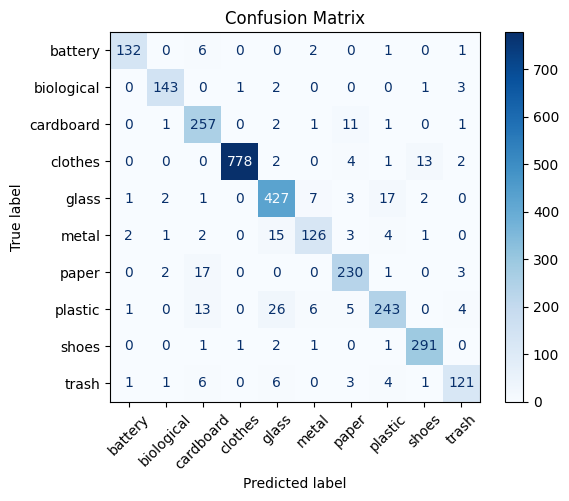

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

#### **Insights:**
- For the ten-class waste classification task, MobileNetV2, the most lightweight pre-trained model with all layers frozen, achieved a solid test accuracy of **92%**.

- Further performance improvement may be possible by experimenting with heavier pre-trained models such as DenseNet121, which have more parameters and deeper feature representations.

- Take a look at detailed classification report:
  - precision of cardboard is relatively low

### **3.2 Pre-trained Model: DenseNet201**

**Version 1: Freeze all base model's layers**

In [ ]:
def densenet_model_ten_v1():

  inputs = Input(shape=IMG_SIZE + (3,))

  # Base model
  base_model = DenseNet201(input_tensor=inputs, include_top=False, weights='imagenet')

  # Freeze all layers initially
  for layer in base_model.layers:
      layer.trainable = False

  x = base_model.output

  # flatten layer
  x = GlobalAveragePooling2D()(x)

  # fully-connected layer
  x = Dense(256, activation='relu', name='tl_feat_dn')(x)

  # dropout layer
  x = Dropout(0.3)(x)

  # output layer
  outputs = Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  # Compile and train
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
epochs = 15

# fit the model using training set
# Compile and fit the model
densenet_model_v1 = densenet_model_ten_v1()

history = densenet_model_v1.fit(
    train_gen_ten,
    validation_data=val_gen_ten,
    callbacks=[early_stop],
    steps_per_epoch=train_gen_ten.samples // BATCH_SIZE,
    validation_steps=val_gen_ten.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Epoch 1/15
276/276 - 245s - 886ms/step - accuracy: 0.8303 - loss: 0.5286 - val_accuracy: 0.9095 - val_loss: 0.2908
Epoch 2/15
276/276 - 9s - 32ms/step - accuracy: 0.7800 - loss: 0.6713 - val_accuracy: 0.9129 - val_loss: 0.2798
Epoch 3/15
276/276 - 174s - 632ms/step - accuracy: 0.8890 - loss: 0.3296 - val_accuracy: 0.9193 - val_loss: 0.2462
Epoch 4/15
276/276 - 8s - 30ms/step - accuracy: 0.9600 - loss: 0.1202 - val_accuracy: 0.9234 - val_loss: 0.2396
Epoch 5/15
276/276 - 173s - 628ms/step - accuracy: 0.9079 - loss: 0.2743 - val_accuracy: 0.9271 - val_loss: 0.2224
Epoch 6/15
276/276 - 8s - 29ms/step - accuracy: 0.8800 - loss: 0.2650 - val_accuracy: 0.9275 - val_loss: 0.2197
Epoch 7/15
276/276 - 173s - 628ms/step - accuracy: 0.9162 - loss: 0.2465 - val_accuracy: 0.9325 - val_loss: 0.2099
Epoch 8/15
276/276 - 8s - 29ms/step - accuracy: 0.9000 - loss: 0.3153 - val_accuracy: 0.9332 - val_loss: 0.2081
Epoch 9/15
276/276 - 173s - 627ms/step - accuracy: 0.9220 - loss: 0.2268 - val_accuracy: 0.9

In [ ]:
# Predict class probabilities
predictions = densenet_model_v1.predict(test_gen_ten, verbose=1)
# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = test_gen_ten.classes

# Get class label names
class_labels = list(test_gen_ten.class_indices.keys())

# Classification report with labels
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 441ms/step
Accuracy: 0.9340289464826658


precision    recall  f1-score      support
battery        0.964286  0.950704  0.957447   142.000000
biological     0.993056  0.953333  0.972789   150.000000
cardboard      0.916968  0.927007  0.921960   274.000000
clothes        0.988679  0.982500  0.985580   800.000000
glass          0.867961  0.971739  0.916923   460.000000
metal          0.828221  0.876623  0.851735   154.000000
paper          0.902439  0.877470  0.889780   253.000000
plastic        0.938697  0.822148  0.876565   298.000000
shoes          0.966667  0.976431  0.971524   297.000000
trash          0.907692  0.825175  0.864469   143.000000
accuracy       0.934029  0.934029  0.934029     0.934029
macro avg      0.927467  0.916313  0.920877  2971.000000
weighted avg   0.935657  0.934029  0.933827  2971.000000

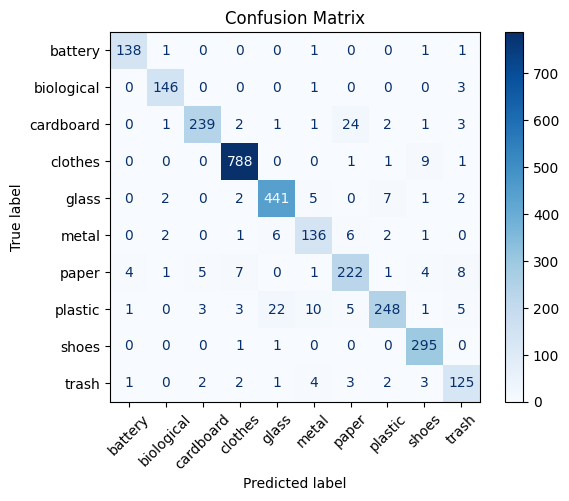

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

**Insights:**

- Replacing MobileNet with DenseNet improved test accuracy from 92% to 93.4%, even with all base model layers frozen.

- Class Metal has relatively low precision (83%), Class Glass has precision of 86.7%. Other classes have precision over 90%.

- Unfreezing some layers of the base model could further enhance performance by allowing fine-tuning on domain-specific features.

- In Version 1, the total number of trainable parameters is around 490K. In Version 2, by unfreezing the last 20 layers, the total number of trainable parameters can increase to around 1M.



**Version 2: Unfreeze the last 20 layers**

- Note from Jessie: The base model contains 707 layers. Unfreezing just the bias and batch normalization layers would result in 401 trainable layers. Given our relatively small training set (~15,000 samples), enabling this many layers risks overfitting and may lead to computational inefficiency without significant performance gain.

- In Version 1, the total number of trainable parameters is around 490K. In Version 2, by unfreezing the last 20 layers, the total number of trainable parameters can **increase to around 1M.**




In [ ]:
def densenet_model_ten_v2():

  inputs = Input(shape=IMG_SIZE + (3,))

  # Base model
  base_model = DenseNet201(input_tensor=inputs, include_top=False, weights='imagenet')

  # Freeze all layers initially
  # Total layers of base model: 707
  for layer in base_model.layers:
      layer.trainable = False
  print("Number of layers in the base model:", len(base_model.layers))

  # Unfreeze the last 20 layers
  for layer in base_model.layers[-20:]:
      layer.trainable = True


  x = base_model.output

  # flatten layer
  x = GlobalAveragePooling2D()(x)

  # fully-connected layer
  x = Dense(256, activation='relu', name='tl_feat_dn')(x)

  # dropout layer
  x = Dropout(0.3)(x)

  # output layer
  outputs = Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  # Compile and train
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
epochs = 15


densenet_model_v2 = densenet_model_ten_v2()

history = densenet_model_v2.fit(
    train_gen_ten,
    validation_data=val_gen_ten,
    callbacks=[early_stop],
    steps_per_epoch=train_gen_ten.samples // BATCH_SIZE,
    validation_steps=val_gen_ten.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Number of layers in the base model: 707
Epoch 1/15
276/276 - 258s - 933ms/step - accuracy: 0.8419 - loss: 0.4937 - val_accuracy: 0.9214 - val_loss: 0.2284
Epoch 2/15
276/276 - 9s - 33ms/step - accuracy: 0.9000 - loss: 0.3484 - val_accuracy: 0.9231 - val_loss: 0.2218
Epoch 3/15
276/276 - 175s - 634ms/step - accuracy: 0.9127 - loss: 0.2711 - val_accuracy: 0.9268 - val_loss: 0.2200
Epoch 4/15
276/276 - 9s - 31ms/step - accuracy: 0.9800 - loss: 0.0922 - val_accuracy: 0.9305 - val_loss: 0.2190
Epoch 5/15
276/276 - 174s - 631ms/step - accuracy: 0.9299 - loss: 0.2108 - val_accuracy: 0.9305 - val_loss: 0.2009
Epoch 6/15
276/276 - 8s - 30ms/step - accuracy: 0.9400 - loss: 0.1701 - val_accuracy: 0.9305 - val_loss: 0.2033
Epoch 7/15
276/276 - 174s - 630ms/step - accuracy: 0.9413 - loss: 0.1832 - val_accuracy: 0.9420 - val_loss: 0.1718
Epoch 8/15
276/276 - 8s - 29ms/step - accuracy: 1.0000 - loss: 0.0580 - val_accuracy: 0.9407 - val_loss: 0.1745
Epoch 9/15
276/276 - 174s - 629ms/step - accuracy: 0

In [ ]:
# Predict class probabilities
predictions = densenet_model_v2.predict(test_gen_ten, verbose=1)
# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = test_gen_ten.classes

# Get class label names
class_labels = list(test_gen_ten.class_indices.keys())

# Classification report with labels
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step
Accuracy: 0.9491753618310333


precision    recall  f1-score      support
battery        0.992593  0.943662  0.967509   142.000000
biological     0.960265  0.966667  0.963455   150.000000
cardboard      0.958015  0.916058  0.936567   274.000000
clothes        0.998721  0.976250  0.987358   800.000000
glass          0.941423  0.978261  0.959488   460.000000
metal          0.838509  0.876623  0.857143   154.000000
paper          0.861210  0.956522  0.906367   253.000000
plastic        0.973881  0.875839  0.922261   298.000000
shoes          0.936508  0.993266  0.964052   297.000000
trash          0.913043  0.881119  0.896797   143.000000
accuracy       0.949175  0.949175  0.949175     0.949175
macro avg      0.937417  0.936427  0.936100  2971.000000
weighted avg   0.951012  0.949175  0.949339  2971.000000

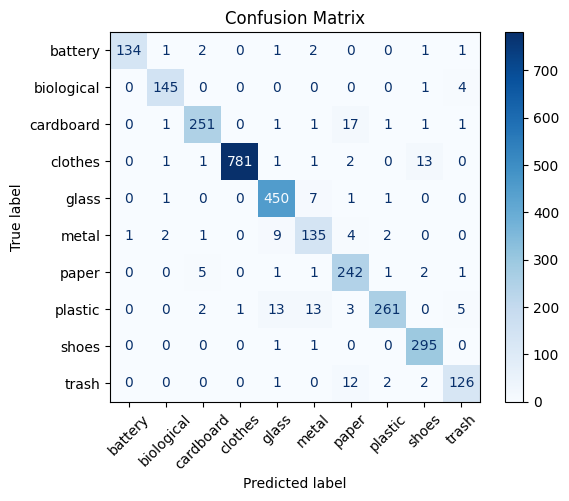

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

**Insights:**

- Unfreezing the last 20 layers of DenseNet201 improved test accuracy from 93.4% to 95%, with only a minor gain despite adding over 60K trainable parameters. This suggests diminishing returns, and further tuning of DenseNet is likely unnecessary.

- Metal class precision rises to 83%, paper precision is 86%. Other classes all have precision higher than 90%

- For further improvement, consider exploring a heavier pre-trained model such as ResNet (44.6M parameters) to leverage deeper feature representations.



### **3.3 Pre-trained Model: ResNet**

resnet101: 44.6M Parameters


First, freeze all layers from the base model to see how ResNet fits in our use cases.

In [ ]:
def ResNet_model_ten_v1():

  inputs = Input(shape=IMG_SIZE + (3,))

  # Base model
  base_model = ResNet101V2(input_tensor=inputs, include_top=False,
                                  weights='imagenet')

  # Freeze all layers initially
  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output

  # flatten layer
  x = GlobalAveragePooling2D()(x)

  # fully-connected layer
  x = Dense(256, activation='relu', name='tl_feat_dn')(x)

  # dropout layer
  x = Dropout(0.3)(x)

  # output layer
  outputs = Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  # Compile and train
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
epochs = 20


resnet_model_v1 = ResNet_model_ten_v1()

history = resnet_model_v1.fit(
    train_gen_ten,
    validation_data=val_gen_ten,
    callbacks=[early_stop],
    steps_per_epoch=train_gen_ten.samples // BATCH_SIZE,
    validation_steps=val_gen_ten.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Epoch 1/20
276/276 - 204s - 740ms/step - accuracy: 0.8458 - loss: 0.4918 - val_accuracy: 0.9173 - val_loss: 0.2646
Epoch 2/20
276/276 - 9s - 31ms/step - accuracy: 0.9200 - loss: 0.2727 - val_accuracy: 0.9176 - val_loss: 0.2663
Epoch 3/20
276/276 - 174s - 630ms/step - accuracy: 0.8996 - loss: 0.3076 - val_accuracy: 0.9261 - val_loss: 0.2226
Epoch 4/20
276/276 - 8s - 30ms/step - accuracy: 0.9000 - loss: 0.3214 - val_accuracy: 0.9271 - val_loss: 0.2231
Epoch 5/20
276/276 - 174s - 630ms/step - accuracy: 0.9114 - loss: 0.2624 - val_accuracy: 0.9315 - val_loss: 0.2145
Epoch 6/20
276/276 - 8s - 29ms/step - accuracy: 0.9600 - loss: 0.1851 - val_accuracy: 0.9312 - val_loss: 0.2141
Epoch 7/20
276/276 - 174s - 632ms/step - accuracy: 0.9229 - loss: 0.2248 - val_accuracy: 0.9339 - val_loss: 0.2246
Epoch 8/20
276/276 - 8s - 29ms/step - accuracy: 0.9800 - loss: 0.0985 - val_accuracy: 0.9322 - val_loss: 0.2293
Epoch 9/20
276/276 - 174s - 631ms/step - accuracy: 0.9264 - loss: 0.2157 - val_accuracy: 0.9

In [ ]:
# Predict class probabilities
predictions = resnet_model_v1.predict(test_gen_ten, verbose=1)
# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = test_gen_ten.classes

# Get class label names
class_labels = list(test_gen_ten.class_indices.keys())

# Classification report with labels
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step
Accuracy: 0.9326825984516998


precision    recall  f1-score      support
battery        0.932432  0.971831  0.951724   142.000000
biological     0.985816  0.926667  0.955326   150.000000
cardboard      0.877133  0.937956  0.906526   274.000000
clothes        0.992405  0.980000  0.986164   800.000000
glass          0.946785  0.928261  0.937431   460.000000
metal          0.851613  0.857143  0.854369   154.000000
paper          0.934783  0.849802  0.890269   253.000000
plastic        0.857143  0.885906  0.871287   298.000000
shoes          0.924051  0.983165  0.952692   297.000000
trash          0.884892  0.860140  0.872340   143.000000
accuracy       0.932683  0.932683  0.932683     0.932683
macro avg      0.918705  0.918087  0.917813  2971.000000
weighted avg   0.933732  0.932683  0.932726  2971.000000

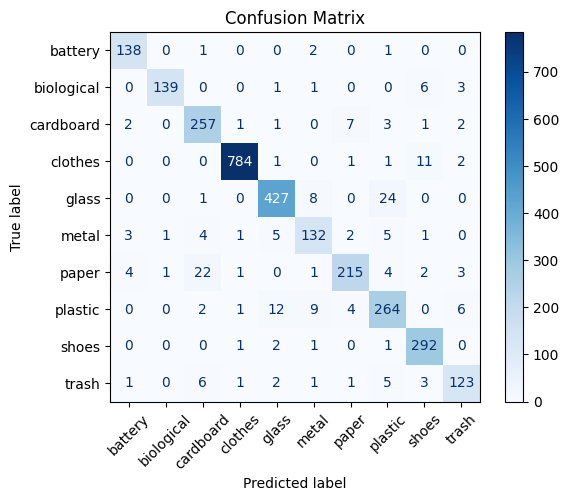

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

**Insights:**

- When all base model layers are frozen, DenseNet outperforms ResNet in overall accuracy and demonstrates more consistent performance across the ten classes.

### **Step 3 Summary**

The following pre-trained models are experimented in 4 trials:

- MobileNet (most lightweighted one): test accuracy of 92%

- DenseNet (medium size):

   - Freeze all layers: test accuracy of 93.4%
   - Unfreeze last 20 layers: test accuracy of 95%

- ResNet (largest model): when freezing all layers, test accuracy 93.3%

The optimal choice is **DenseNet with the last 20 layers unfreezed**



In [ ]:
optimal_step3_model = densenet_model_v2

In [ ]:
# Visualize: Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    # Create a model that maps input to the conv layer and final predictions
    grad_model = Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])  # Top predicted class index
        loss = predictions[:, pred_index]       # Class-specific loss

    # Get gradients of the loss w.r.t. the last conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Compute mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its importance
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

# main function
def ten_class_gradcam(last_layer, model):

  # labels
  ten_labels = ['biological', 'paper', 'cardboard', 'clothes', 'shoes',
                'metal', 'glass', 'battery', 'trash', 'plastic']

  # Define paths
  ten_label_dir_paths = []
  for label in ten_labels:
    ten_label_dir_paths.append(os.path.join(split_path_ten, f'test/{label}'))

  ten_label_image_paths = []
  # Get all image filenames
  for dir in ten_label_dir_paths:
    images = os.listdir(dir)
    sampled_image = random.sample(images, 1)
    ten_label_image_paths.append(os.path.join(dir, sampled_image[0]))

  for img_path in ten_label_image_paths:
    img_array, original_img = preprocess_img(img_path, IMG_SIZE)

    # Get heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_layer)

    # Overlay and display
    display_gradcam(original_img, heatmap)

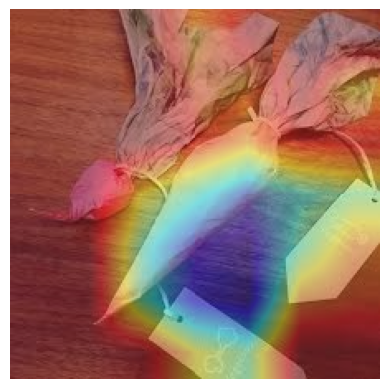

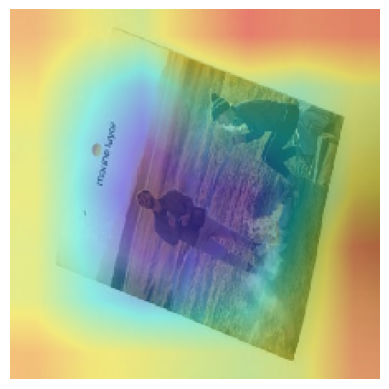

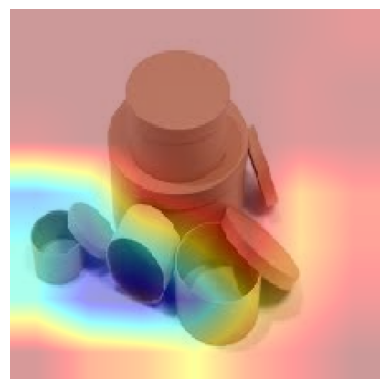

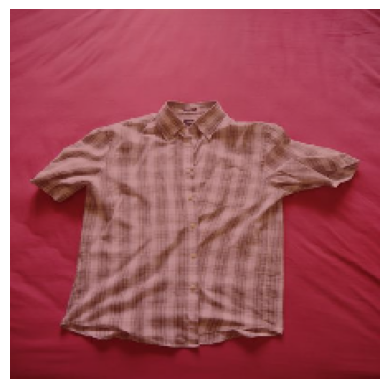

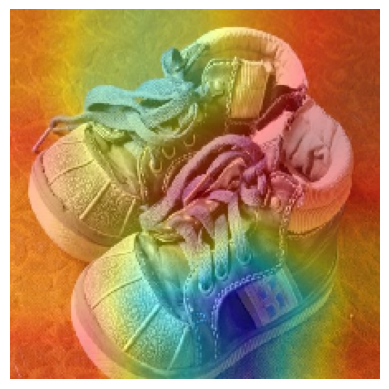

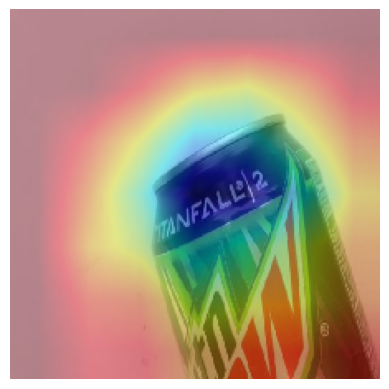

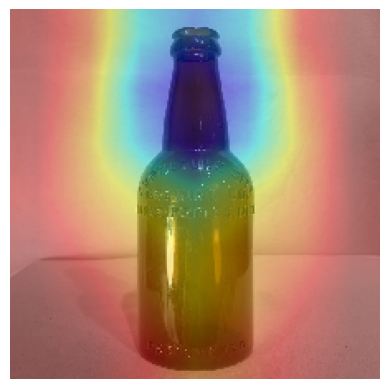

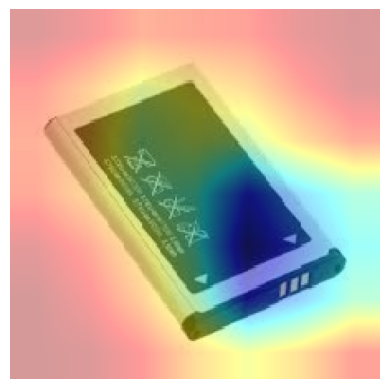

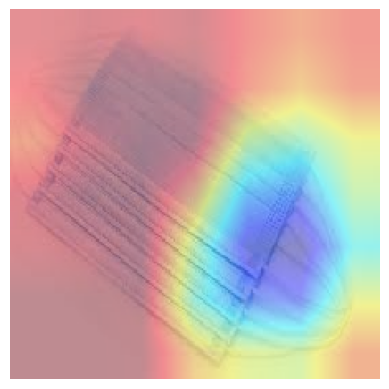

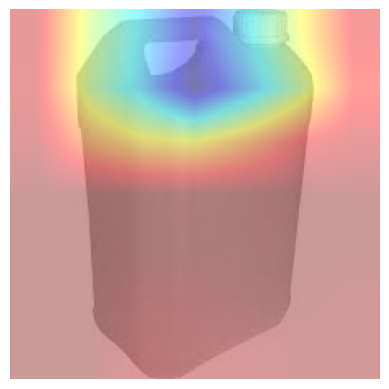

In [ ]:
ten_class_gradcam('conv5_block32_concat', optimal_step3_model)


 ## **Step 4: Multi-Class Classification with DP-CNN**

**DP-CNN:**

- In the previous step, we applied **transfer learning using DenseNet201 as the base model and achieved a strong performance of 95% test accuracy by unfreezing the last 20 layers for fine-tuning.**

- Building on this, we now aim to further enhance performance by **combining DenseNet201 with a custom Deep Parallel CNN (DP-CNN) structure.** Specifically, we extract intermediate feature maps from DenseNet and pass them through 3 parallel convolutional branches with varied kernel sizes, allowing the model to capture multi-scale spatial patterns. This hybrid architecture is designed to leverage the representational power of DenseNet while enriching it with task-specific, multi-resolution features via the DP-CNN module.



In [ ]:
def dp_cnn_transfer():

    inputs = Input(shape=IMG_SIZE + (3,))

    # Load DenseNet201 as base (without top layers)
    base_model = DenseNet201(include_top=False, input_tensor=inputs, weights='imagenet')
    # freeze all base modellayers
    base_model.trainable = False
    # Extract feature maps
    base_features = base_model.output

    # Use 3 branches in parallel to avoid overfitting (we only have around 15K training records)
    branch1 = Conv2D(16, kernel_size=(7, 7), activation='relu', padding='same')(base_features)
    branch2 = Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same')(base_features)
    branch3 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(base_features)

    # Concatenate all branches
    concatenated = Concatenate()([branch1, branch2, branch3])

    # Global average pooling
    gap = GlobalAveragePooling2D()(concatenated)

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(gap)
    fc1 = Dropout(0.2)(fc1)

    # output layer
    output = Dense(10, activation='softmax')(fc1)

    # Build model
    model = Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model_dp_cnn = dp_cnn_transfer()

epochs = 10

history = model_dp_cnn.fit(
    train_gen_ten,
    validation_data=val_gen_ten,
    callbacks=[],
    steps_per_epoch=train_gen_ten.samples // BATCH_SIZE,
    validation_steps=val_gen_ten.samples // BATCH_SIZE,
    epochs=epochs,
    verbose=2
)

Epoch 1/10
276/276 - 245s - 887ms/step - accuracy: 0.7821 - loss: 0.6986 - val_accuracy: 0.8871 - val_loss: 0.3666
Epoch 2/10
276/276 - 11s - 38ms/step - accuracy: 0.8600 - loss: 0.5343 - val_accuracy: 0.8841 - val_loss: 0.3764
Epoch 3/10
276/276 - 169s - 613ms/step - accuracy: 0.8646 - loss: 0.4417 - val_accuracy: 0.9068 - val_loss: 0.3157
Epoch 4/10
276/276 - 10s - 38ms/step - accuracy: 0.8600 - loss: 0.3583 - val_accuracy: 0.9054 - val_loss: 0.3166
Epoch 5/10
276/276 - 169s - 612ms/step - accuracy: 0.8796 - loss: 0.3828 - val_accuracy: 0.9081 - val_loss: 0.2946
Epoch 6/10
276/276 - 10s - 38ms/step - accuracy: 0.9000 - loss: 0.2578 - val_accuracy: 0.9115 - val_loss: 0.2942
Epoch 7/10
276/276 - 168s - 610ms/step - accuracy: 0.8883 - loss: 0.3555 - val_accuracy: 0.9146 - val_loss: 0.2748
Epoch 8/10
276/276 - 10s - 38ms/step - accuracy: 0.8600 - loss: 0.2627 - val_accuracy: 0.9149 - val_loss: 0.2758
Epoch 9/10
276/276 - 171s - 621ms/step - accuracy: 0.8981 - loss: 0.3274 - val_accuracy:

In [ ]:
# save the model for next step's reuse
model_dp_cnn.save('./dp_cnn.keras')

In [ ]:
# Predict class probabilities
predictions = model_dp_cnn.predict(test_gen_ten, verbose=1)
# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = test_gen_ten.classes

# Get class label names
class_labels = list(test_gen_ten.class_indices.keys())

# Classification report with labels
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()

60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 434ms/step
Accuracy: 0.9272972063278357


precision    recall  f1-score      support
battery        0.957447  0.950704  0.954064   142.000000
biological     0.933775  0.940000  0.936877   150.000000
cardboard      0.911439  0.901460  0.906422   274.000000
clothes        0.994937  0.982500  0.988679   800.000000
glass          0.912017  0.923913  0.917927   460.000000
metal          0.828221  0.876623  0.851735   154.000000
paper          0.852713  0.869565  0.861057   253.000000
plastic        0.893617  0.845638  0.868966   298.000000
shoes          0.942492  0.993266  0.967213   297.000000
trash          0.875000  0.832168  0.853047   143.000000
accuracy       0.927297  0.927297  0.927297     0.927297
macro avg      0.910166  0.911584  0.910599  2971.000000
weighted avg   0.927587  0.927297  0.927220  2971.000000

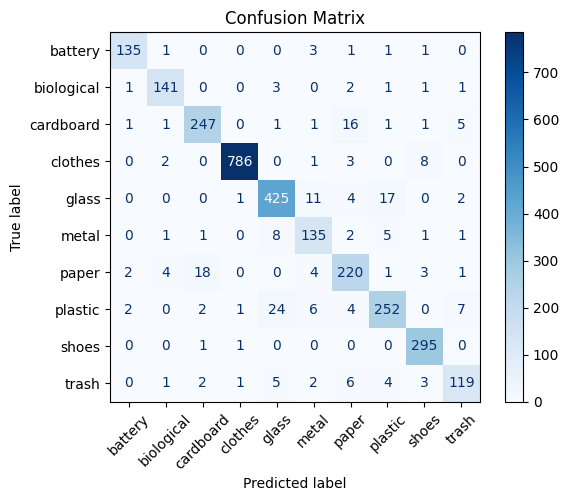

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### **Step 4 Summary:**

Compared to using DenseNet201 as a frozen base model (all layers non-trainable), integrating the DP-CNN module achieves a test accuracy of 92-93%.

- No improvement from Step 3. The experiment 3 fails.

### **Visualize the DP-CNN with transfer learning: Grad-CAM**

**Jessie**

In [ ]:
optimal_step4_model = load_model('./dp_cnn.keras', compile=False)

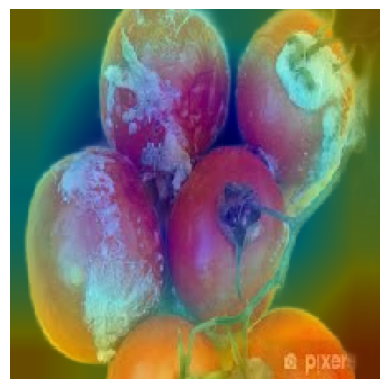

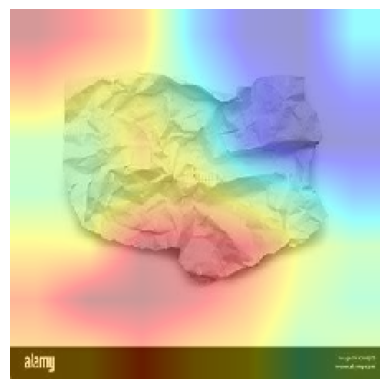

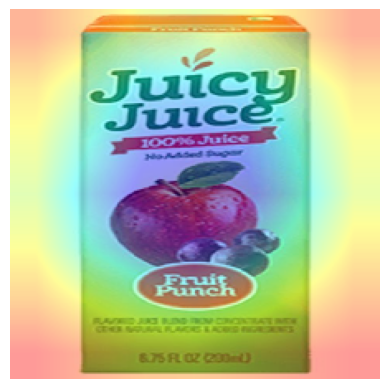

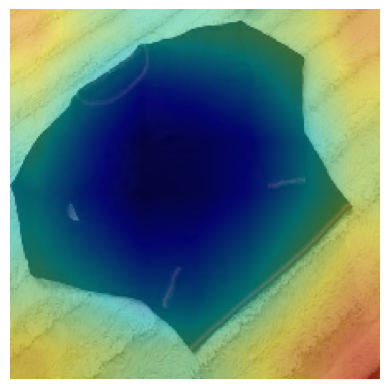

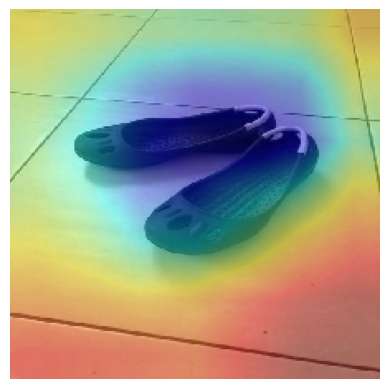

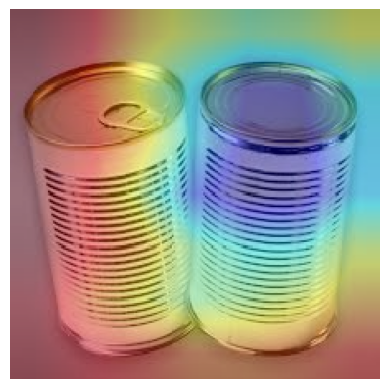

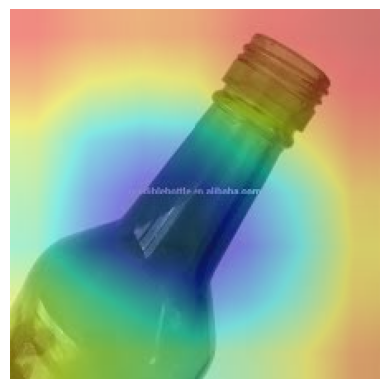

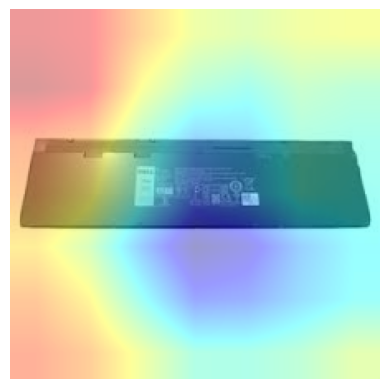

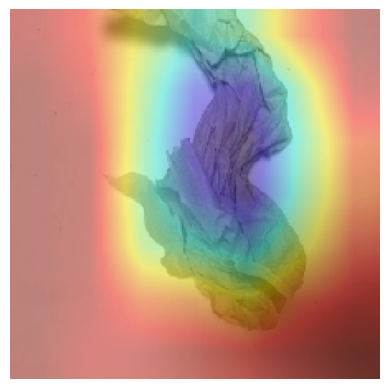

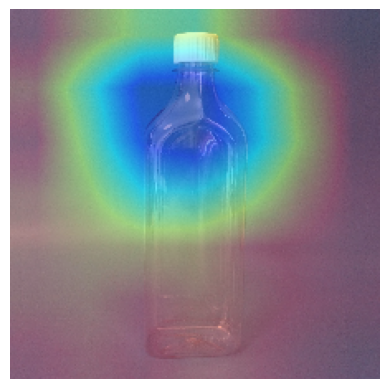

In [ ]:
ten_class_gradcam('concatenate_8', optimal_step4_model)

 ## **Step 5: Multi-Class Classification with En-ELM**

In this step, we explore whether integrating an Ensemble Extreme Learning Machine (En-ELM) on top of transfer learning can further improve performance and potentially surpass the optimal test accuracy of 95% achieved in Step 3.


### **5.1 Data Preparation for En-ELM**

In [ ]:
# Train generator with Shuffle=False
train_gen_no_shuffle = train_datagen.flow_from_directory(
    os.path.join(split_path_ten, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 18003 images belonging to 10 classes.


In [ ]:
# Step 1: Load the optimal trained model from step 3.
# Current test accuracy: 92.7%
step3_model = load_model('./optimal_model_step3.keras', compile=False)

# Step 2: Extract fc1 features from the fully-connected layer
feature_extraction = Model(inputs=step3_model.input, outputs=step3_model.layers[-3].output)

X_train = feature_extraction.predict(train_gen_no_shuffle)
y_train = train_gen_no_shuffle.classes

X_val = feature_extraction.predict(val_gen_ten)
y_val = val_gen_ten.classes

X_test = feature_extraction.predict(test_gen_ten)
y_test = test_gen_ten.classes

361/361 ━━━━━━━━━━━━━━━━━━━━ 251s 648ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 333ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step


In [ ]:
# Step 3:  Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

encoder = OneHotEncoder()
Y_train = encoder.fit_transform(y_train.reshape(-1, 1))
Y_val   = encoder.transform(y_val.reshape(-1, 1))
Y_test  = encoder.transform(y_test.reshape(-1, 1))

### **5.2 En-ELM Model with L2 Regularization**

In [ ]:
# PI-ELM
def elm_train_pinv(X, Y, n_hidden):
    W = np.random.randn(X.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H = 1 / (1 + np.exp(- (X @ W + b[np.newaxis, :])))  # activation function: Sigmoid
    beta = pinv(H) @ Y
    return W, b, beta

# L2-RELM
def elm_train_ridge(X, Y, n_hidden, alpha):
    W = np.random.randn(X.shape[1], n_hidden)
    b = np.random.randn(n_hidden)
    H = 1 / (1 + np.exp(- (X @ W + b[np.newaxis, :])))  # activation function: Sigmoid,
    A = H.T @ H + alpha * np.eye(n_hidden)
    beta = np.linalg.inv(A) @ H.T @ Y
    return W, b, beta

# Prediction Function
def elm_predict(X, W, b, beta):
    H = 1 / (1 + np.exp(- (X @ W + b[np.newaxis, :])))  # activation function: Sigmoid
    return H @ beta

In [ ]:
# Grid search hyperparameters on the validation set
best_score  = 0
best_params = {}

for n_h in (500, 1000):
    for alpha in (1e-4, 1e-3, 1e-2):

        # Train ELM1 (pinv) and ELM2 (ridge)
        W1, b1, β1 = elm_train_pinv(X_train, Y_train, n_h)
        W2, b2, β2 = elm_train_ridge(X_train, Y_train, n_h, alpha)

        # Predict on validation set
        Yv1 = elm_predict(X_val, W1, b1, β1)
        Yv2 = elm_predict(X_val, W2, b2, β2)

        # Ensemble prediction
        yv_pred = np.argmax((Yv1 + Yv2) / 2, axis=1)
        acc_v = accuracy_score(y_val, yv_pred)

        # Track best
        if acc_v > best_score:
            best_score = acc_v
            best_params = {'n_hidden': n_h, 'alpha': alpha}

print(f"\nBest validation acc: {best_score:.4f}, params: {best_params}")


Best validation acc: 0.9681, params: {'n_hidden': 1000, 'alpha': 0.0001}


In [ ]:
# Final EN-ELM evaluation on the test set using best hyperparameters
n_h   = best_params['n_hidden']
alpha = best_params['alpha']

W1, b1, β1 = elm_train_pinv(X_train, Y_train, n_h)
W2, b2, β2 = elm_train_ridge(X_train, Y_train, n_h, alpha)

Yt1  = elm_predict(X_test, W1, b1, β1)
Yt2  = elm_predict(X_test, W2, b2, β2)
y_pred = np.argmax((Yt1+Yt2)/2, axis=1)

print("\n=== Final En-ELM on Test ===")
print(f"Overall En-ELM Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
class_labels = list(test_gen_ten.class_indices.keys())
report = classification_report(y_test, y_pred,
                               target_names = class_labels,
                               digits=4,
                               output_dict=True)
print("Accuracy:", report['accuracy'])
pd.DataFrame(report).transpose()


=== Final En-ELM on Test ===
Overall En-ELM Accuracy: 0.9726

Accuracy: 0.9726127442030309


precision    recall  f1-score      support
battery        0.988764  0.988764  0.988764   267.000000
biological     1.000000  0.963100  0.981203   271.000000
cardboard      0.977956  0.962525  0.970179   507.000000
clothes        0.995267  0.990579  0.992917  1486.000000
glass          0.970862  0.976553  0.973700   853.000000
metal          0.904290  0.964789  0.933560   284.000000
paper          0.947146  0.971800  0.959315   461.000000
plastic        0.978641  0.931608  0.954545   541.000000
shoes          0.969369  0.994455  0.981752   541.000000
trash          0.917603  0.921053  0.919325   266.000000
accuracy       0.972613  0.972613  0.972613     0.972613
macro avg      0.964990  0.966523  0.965526  5477.000000
weighted avg   0.973041  0.972613  0.972664  5477.000000

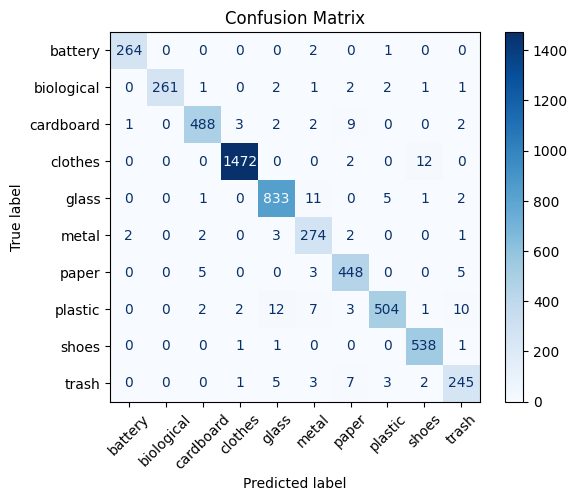

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = list(test_gen_ten.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

**Insights:**

- Integrating En-ELM into the DP-CNN model from Step 3 enhances test accuracy **from 95% to 97%**, resulting in more consistent performance across all ten classes.